In [ ]:
# El objetivo de esta tarea es:
# 1) Implementar convolucion (usando cython)
# 2) Implementar piramides de Gauss y Laplace
# 3) Implementar reconstruccion de una imagen a partir de las piramides
# 4) Graficar las piramides
#
# Nota: los arreglos (matrices) creados deben ser de tipo np.float32

In [ ]:
# Si se usa colaboratory, esta linea permite subir imagenes a la carpeta del notebook
from google.colab import files
uploaded = files.upload()

Saving frutas.png to frutas.png
Saving madera.png to madera.png
Saving poligonos.png to poligonos.png
Saving techo.png to techo.png


In [ ]:
# Mostrar archivos en la carpeta del notebook
!ls

frutas.png  madera.png	poligonos.png  sample_data  techo.png


In [ ]:
# Para medir tiempo de ejecucion
!pip install ipython-autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1831 sha256=0e4f11b872ad245ac2f597fe179c441b8126d33480e65eb2b6f187bbe7ba0726
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [ ]:
# Extensiones
%load_ext Cython
%load_ext autotime

In [ ]:
# Paquetes a ser usados
import numpy as np
import cv2
import cython
import numpy as np
import math
import matplotlib.pyplot as plt

# Este paquete solo se debe usar si se usa colaboratory
from google.colab.patches import cv2_imshow

time: 480 ms


In [ ]:
%%cython
cimport numpy as np
import numpy as np
import cython

# La convolucion debe ser implementada usando cython (solo esta funcion en cython)

cpdef float[:, :] convolution_cython(float [:, :] input, float [:, :] mask):
  cdef int r, c, rows, cols, k_rows, k_cols, m, n, mm , nn, k_center_x, k_center_y
  cdef np.ndarray output = np.zeros((input.shape[0], input.shape[1]), dtype = np.float32)

  # tamano de la imagen, máscara y centro de la máscara
  rows = input.shape[0]
  cols = input.shape[1]
  k_rows = mask.shape[0]
  k_cols = mask.shape[1]
  k_center_x = k_cols//2
  k_center_y = k_rows//2

  # Convolucion entre "input" y "mask"
  for r in range(rows):
      for c in range(cols):
        if ((c >= k_center_x and c + k_cols - k_center_x <= cols) 
        and (r >= k_center_y  and r + k_rows - k_center_y <= rows)):
          for m in range(k_rows):
            mm = k_rows - 1 - m
            for n in range(k_cols):
              nn = k_cols - 1 - n
              ii = r + m - k_center_y
              jj = c + n - k_center_x
              output[r,c] += input[ii,jj] * mask[mm,nn]
        else:
          output[r,c] = input[r,c]
  return output


time: 5.07 s


In [ ]:
def compute_gauss_horiz(sigma, width):
	mask = np.zeros((1, width), np.float32)
	# Por hacer: implementar calculo de mascara gaussiana horizontal pixel a pixel
	suma = 0
	centro = (width-1)/2

	for i in range(width):
		mask[0,i] = math.exp(-((i-centro)**2)/(2*sigma**2) ) / (sigma*math.sqrt(2*math.pi))
		suma += mask[0,i] 
	# Se debe normalizar tras calcularla para que las sumas de los pixeles sea igual a 1
	mask = mask/suma

	return mask


time: 4.71 ms


In [ ]:
def compute_gauss_vert(sigma, height):
	mask = np.zeros((height, 1), np.float32)
	# Por hacer: implementar calculo de mascara gaussiana vertical pixel a pixel
	suma = 0
	centro = (height-1)/2

	for j in range(height):
		mask[j,0] = math.exp(-((j-centro)**2)/(2*sigma**2) ) / (sigma*math.sqrt(2*math.pi))
		suma += mask[j,0] 
	# Se debe normalizar tras calcularla para que las sumas de los pixeles sea igual a 1
	mask = mask/suma
	
	return mask


time: 7.56 ms


In [ ]:
def do_blur(input, sigma, height):
	# Por hacer:
	# 1) Calcular mascara gaussiana horizontal con parametros sigma y height
	horizontal_mask = compute_gauss_horiz(sigma, height)
	# 2) Calcular mascara gaussiana vertical con parametros sigma y height
	vertical_mask = compute_gauss_vert(sigma, height)
	# 3) Calcular convolucion entre la imagen de entrada "input" y la mascara horizontal
	horizontal_conv = convolution_cython(input, horizontal_mask)
	# 4) Calcular convolucion entre la imagen resultante y la mascara vertical
	vertical_conv = convolution_cython(horizontal_conv, vertical_mask)
	
	return vertical_conv


time: 3.34 ms


In [ ]:
def subsample(input):
	# por hacer: implementar submuestreo pixel a pixel
	rows = input.shape[0]
	cols = input.shape[1]
	container = np.zeros(( rows//2, cols//2 ))
	for i in range(1, rows, 2):
		for j in range(1, cols, 2):
			container[i//2, j//2] = input[i, j]
	return container

time: 2.69 ms


In [ ]:
def compute_gauss_pyramid(input, nlevels):  
  gausspyramid = []
  current = np.copy(input.astype(np.float32))
  gausspyramid.append(current)
  for i in range(1,nlevels):
    # Por hacer:
    # 1) Aplicar do_blur a la imagen gausspyramid[i-1], con sigma 2.0 y ancho 7
    blur = do_blur(gausspyramid[i-1], 2, 7)
    # 2) Submuestrear la imagen resultante usando subsample y guardando el resultado en current
    sub = subsample(blur).astype(np.float32)
    current = np.copy(sub)
    gausspyramid.append(current)
  return gausspyramid

time: 4.84 ms


In [ ]:
def show_gauss_pyramid(pyramid, name = None):
  # Por hacer: mostrar las imagenes de la piramide de gauss
  fig, ax = plt.subplots(1, 5 ,figsize=[20,13])
  for i,image in enumerate(pyramid):
    ax[i].imshow(scale_abs(image,1), cmap=plt.get_cmap('gray'))
    ax[i].set_title(f'Nivel {i+1}')
  if name:
    plt.savefig(name + '.jpg')

time: 6.07 ms


In [ ]:
def subtract(input1, input2):
  # Por hacer: calcular la resta entre input1 e input2, pixel a pixel
  assert(input1.shape == input2.shape)
  output = np.zeros_like(input1)
  for i in range(input1.shape[0]):
    for j in range(input2.shape[1]):
      output[i,j] = input1[i,j] - input2[i,j]
  return output

time: 3.26 ms


In [ ]:
def add(input1, input2):
  # Por hacer: calcular la resta entre input1 e input2, pixel a pixel
  assert(input1.shape == input2.shape)
  output = np.zeros_like(input1)
  for i in range(input1.shape[0]):
    for j in range(input2.shape[1]):
      output[i,j] = input1[i,j] + input2[i,j]
  return output

time: 2.87 ms


In [ ]:
def scale_abs(input, factor):
  # Por hacer: aplicar valor absoluto a los pixeles de la imagen pixel a pixel y luego escalar los pixeles usando el factor indicado
  output = np.copy(input) # Esta linea se debe eliminar
  for i in range(output.shape[0]):
    for j in range(output.shape[1]):
      output[i,j] = abs(input[i,j])/factor
  return output

time: 2.13 ms


In [ ]:
def compute_laplace_pyramid(input, nlevels):
  gausspyramid = []
  laplacepyramid = []
  current = np.copy(input.astype(np.float32))
  gausspyramid.append(current)
  for i in range(1, nlevels):
    # Por hacer:
    # 1) Aplicar do_blur( ) a la imagen gausspyramid[i-1], con sigma 2.0 y ancho 7
    blur = do_blur(gausspyramid[i-1], 2, 7)
    # 2) Guardar en laplacepiramid el resultado de restar gausspyramid[i - 1] y la imagen calculada en (1)
    sub = subtract(gausspyramid[i-1], blur)
    #scale = scale_abs(sub, 2)
    laplacepyramid.append(np.copy(sub))  # Esta linea se debe reemplazar por lo indicado en (2)
    # 3) Submuestrear la imagen calculada en (1), guardar el resultado en current
    current = subsample(blur).astype(np.float32)
    gausspyramid.append(current)
  laplacepyramid.append(current)  # Se agrega el ultimo piso de la piramide de Laplace
  return laplacepyramid

time: 11.3 ms


In [ ]:
def show_laplace_pyramid(pyramid, name = None):
  # Por hacer: mostrar las imagenes de la piramide de laplace:
  #  Las imagenes deben ser escaladas antes de mostrarse usando scale_abs
  #  Sin embargo, la ultima imagen del ultimo piso se muestra tal cual
  # Se recomienda usar cv2_imshow( ) para mostrar las imagenes
  fig, ax = plt.subplots(1, 5 ,figsize=[20,13])
  for i,image in enumerate(pyramid[:-1]):
    ax[i].imshow(scale_abs(image,1), cmap=plt.get_cmap('gray'))
    ax[i].set_title(f'Nivel {i+1}')
  ax[-1].imshow(pyramid[-1], cmap=plt.get_cmap('gray'))
  ax[-1].set_title(f'Nivel {len(pyramid)}')
  if name:
    plt.savefig(name+'.jpg')

time: 6.35 ms


In [ ]:
def upsample(input):
  # Por hacer: implementar duplicacion del tamaño de imagen pixel a pixel
  # Un pixel de la imagen de salida debe ser el promedio de los 4 pixeles mas cercanos de la imagen de entrada
  # Se debe tener cuidado de que los indices no salgan fuera del tamano de la imagen
  rows = input.shape[0]
  cols = input.shape[1]
  output = np.zeros((rows*2, cols*2))
  for i in range(rows):
    for j in range(cols):
      output[i*2,j*2] = input[i, j]
      output[i*2+1, j*2] = input[i, j]
      output[i*2, j*2+1] = input[i, j]
      output[i*2+1, j*2+1] = input[i, j]
  
  for i in range(rows*2):
    for j in range(cols*2):  
      if i != (rows*2 - 1) and i != 0 and j != (cols*2 - 1) and j != 0:
        output[i,j] = (output[i-1,j] + output[i,j-1] + output[i+1,j] + output[i,j+1])/4

  return output


time: 13.4 ms


In [ ]:
def reconstruct(laplacepyramid):
  output = np.copy( laplacepyramid[-1] )
  for i in range(1, len(laplacepyramid)):
    lev = int(len(laplacepyramid)) - i - 1
    # Por hacer: repetir estos dos pasos:
    # (1) Duplicar tamano output usando upsample( )
    up = upsample(output)
    # (2) Sumar resultado de (1) y laplacepyramid[lev] usando add( ), almacenar en output
    output = add(up, laplacepyramid[lev])
  return output

time: 3.31 ms


In [ ]:
!wget https://pbs.twimg.com/profile_images/588793497630732288/J1sptcX4_400x400.png

--2020-09-28 19:34:39--  https://pbs.twimg.com/profile_images/588793497630732288/J1sptcX4_400x400.png
Resolving pbs.twimg.com (pbs.twimg.com)... 192.229.237.96
Connecting to pbs.twimg.com (pbs.twimg.com)|192.229.237.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82752 (81K) [image/png]
Saving to: ‘J1sptcX4_400x400.png’

J1sptcX4_400x400.pn 100%[===================>]  80.81K  --.-KB/s    in 0.1s    

2020-09-28 19:34:40 (741 KB/s) - ‘J1sptcX4_400x400.png’ saved [82752/82752]

time: 535 ms


In [ ]:
#originalRGB = cv2.imread('frutas.png') #Leer imagen
#originalRGB = cv2.imread('madera.png') #Leer imagen
#originalRGB = cv2.imread('poligonos.png') #Leer imagen
originalRGB = cv2.imread('techo.png') #Leer imagen
#originalRGB = cv2.imread('/content/J1sptcX4_400x400.png')
if originalRGB is None:
  assert False, 'Imagen no encontrada'

if len(originalRGB.shape) == 3:
  original = cv2.cvtColor(originalRGB, cv2.COLOR_BGR2GRAY)
else:
  original = originalRGB

input = np.float32( original )

cv2.imwrite('techo.jpg',input)

True

time: 17.3 ms


Piramide de gauss:
Piramide de laplace:
reconstruida:


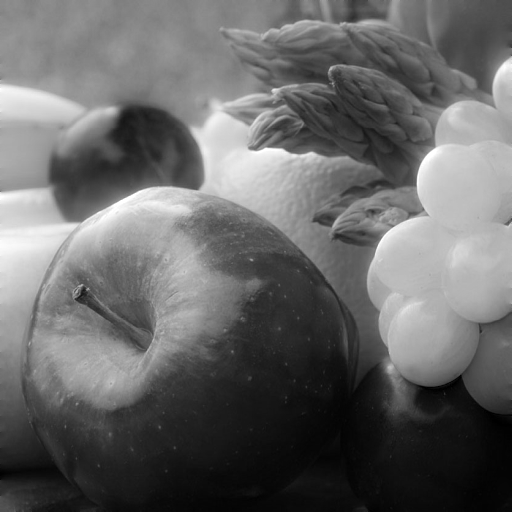

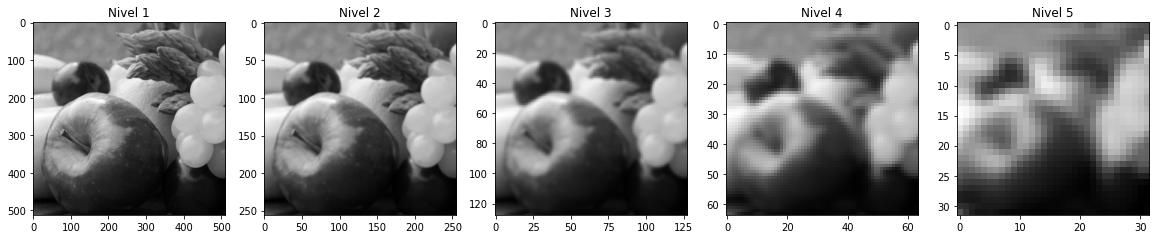

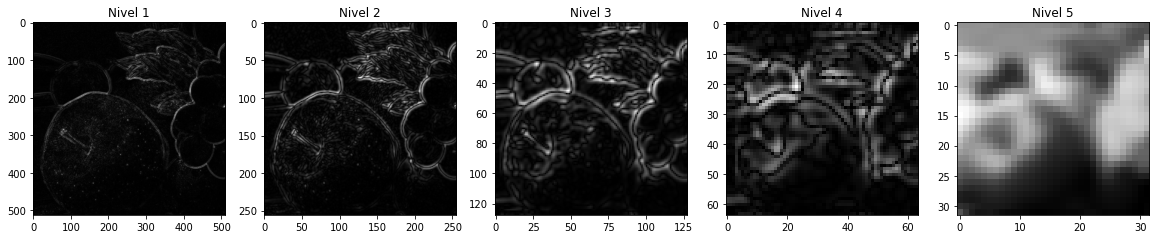

time: 31.1 s


In [ ]:
originalRGB = cv2.imread('frutas.png') #Leer imagen
#originalRGB = cv2.imread('madera.png') #Leer imagen
#originalRGB = cv2.imread('poligonos.png') #Leer imagen
#originalRGB = cv2.imread('techo.png') #Leer imagen
#originalRGB = cv2.imread('/content/J1sptcX4_400x400.png')
if originalRGB is None:
  assert False, 'Imagen no encontrada'

if len(originalRGB.shape) == 3:
  original = cv2.cvtColor(originalRGB, cv2.COLOR_BGR2GRAY)
else:
  original = originalRGB

input = np.float32( original )

print('Piramide de gauss:')
gausspyramid = compute_gauss_pyramid(input, 5)
show_gauss_pyramid(gausspyramid)

print('Piramide de laplace:')
laplacepyramid = compute_laplace_pyramid(input, 5)
show_laplace_pyramid(laplacepyramid)

print('reconstruida:')
reconstr = reconstruct(laplacepyramid)
cv2_imshow(scale_abs(reconstr,1))

In [ ]:
name = 'frutas'
cv2.imwrite(name+'_reconstruida.jpg',scale_abs(reconstr,1))

True

time: 197 ms


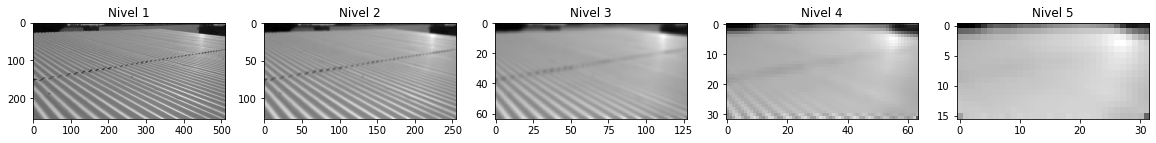

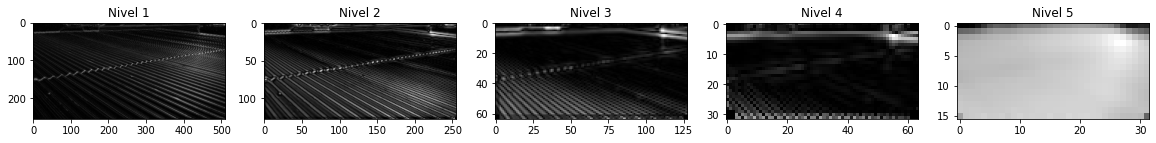

time: 3.07 s


In [ ]:

show_gauss_pyramid(gausspyramid, 'gauss_'+name)
show_laplace_pyramid(laplacepyramid, 'laplace_'+name)